## SMART CITY PROJECT

<img src="smart-city-labos.jpeg" alt="Getting started" />

#### Project context

<dl>

  <dd>Our project is about the analysis for the improvement of the management of all kinds of anomalies declared in Paris. 
We will proceed to these analyses by using a dataset that we extracted from the site : <a href="https://opendata.paris.fr/explore/dataset/dans-ma-rue/">Open Data Paris</a>
.  All of our analyses on this dataset will be done from January 1, 2019 - April 2022.


We will proceed to the cleaning, and to the analyses of the dataset of the other one to know the extent of the information which we can draw from it.

At the end of our study we will be able to bring recommendations to the city of Paris to improve the management and correction of anomalies according to several criteria.

Enjoy ! </dd>
<dl>

### Presented to you by:

Constantin Bogdanas & Anissa Hacene


In [1]:
# importing the needed libaries
from zipfile import ZipFile, Path
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import warnings


/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Anomalies Data

<b>Data import and cleaning</b>


In [25]:
# Declaring the function used for the next steps
def get_data(path: str) -> pd.DataFrame:
    """
    Get data from zip file
    """
    with ZipFile(path) as myzip:
        data = myzip.open(path.split(".zip")[0])
    df = pd.read_csv(data, sep=";")
    return df

##### Data cleaning


In [3]:
df_2021_2022 = get_data("DMR_2021_2022.csv.zip")
df_2020 = get_data("DMR_2020.csv.zip")
df_2019 = get_data("DMR_2019.csv.zip")


In [4]:
df_2021_2022[["X", "Y"]] = df_2021_2022["geo_point_2d"].str.split(",", expand=True)


In [5]:
df_2021_2022 = df_2021_2022.drop(
    [
        "ID DECLARATION",
        "VILLE",
        "ANNEE DECLARATION",
        "MOIS DECLARATION",
        "OUTIL SOURCE",
        "ID_DMR",
        "geo_shape",
        "geo_point_2d",
        "CONSEIL DE QUARTIER",
    ],
    axis=1,
)


In [6]:
df_2019_2020 = pd.concat([df_2019, df_2020])
df_2019_2020 = df_2019_2020.drop(
    [
        "OBJECTID",
        "ID_DMR",
        "VILLE",
        "ANNEEDECL",
        "MOISDECL",
        "NUMERO",
        "PREFIXE",
        "CONSEILQUARTIER",
    ],
    axis=1,
)


In [7]:
df_2019_2020.rename(
    columns={
        "TYPE": "TYPE DECLARATION",
        "SOUSTYPE": "SOUS TYPE DECLARATION",
        "CODE_POSTAL": "CODE POSTAL",
        "DATEDECL": "DATE DECLARATION",
    },
    inplace=True,
)
df_2019_2020.rename(columns={"Y": "LONGITUDE", "X": "LATITUDE"}, inplace=True)
df_2021_2022.rename(columns={"X": "LONGITUDE", "Y": "LATITUDE"}, inplace=True)
df_final = pd.concat([df_2021_2022, df_2019_2020])


In [8]:
df_final.head()


TYPE DECLARATION  \
0                          Mobiliers urbains   
1                          Objets abandonnés   
2                          Objets abandonnés   
3  Graffitis, tags, affiches et autocollants   
4                          Objets abandonnés   

                     SOUS TYPE DECLARATION  \
0     Collecte des déchets:Trilib' dégradé   
1     Autres objets encombrants abandonnés   
2     Autres objets encombrants abandonnés   
3  Graffitis sur mur, façade sur rue, pont   
4                                  Cartons   

                                 ADRESSE  CODE POSTAL  ARRONDISSEMENT  \
0        18 Rue de Mazagran, 75010 PARIS        75010              10   
1       58 Rue de l'Aqueduc, 75010 PARIS        75010              10   
2     106 Rue des Amandiers, 75020 PARIS        75020              20   
3  14 Rue Carrière-Mainguet, 75011 PARIS        75011              11   
4     1 Square Alfred Capus, 75016 PARIS        75016              16   

  DATE DECLARATION                                 INTERVENANT  \
0       2021-01-08                                     TRILIB'   
1       2021-01-08  Ramen en tant que prestataire de DansMaRue   
2       2021-01-08  Ramen en tant que prestataire de DansMaRue   
3       2021-01-08                                   graffitis   
4       2021-01-08                                 DPE-STPP-DT   

            LONGITUDE           LATITUDE  
0    48.8707730016144  2.352240998304316  
1   48.88284700351721  2.365264406238782  
2   48.86777999827195  2.388730996327768  
3  48.856599995660474  2.387607803079172  
4   48.85093700329557  2.259631402809926

<b>Visualisation and interpretation</b>


In [9]:
arrondissement_count = df_final["ARRONDISSEMENT"].value_counts()

fig = px.bar(
    arrondissement_count,
    x=arrondissement_count.index,
    y="ARRONDISSEMENT",
    hover_data=[arrondissement_count.index, "ARRONDISSEMENT"],
    color="ARRONDISSEMENT",
    title="Number of anomalies by district",
    labels={"index": "District number", "ARRONDISSEMENT": "District"},
    height=400,
)
fig.update_xaxes(type="category")
fig.show()
# USE INDEX AS X AXIS


<b>Bar chart interpretation</b>

<dl>
Here we can see the the number of declarations made in each arrondissement of Paris. </dl>
<li>We can see that the most frequent district is the 18th district which comes in first (or last) position with more than ~200k declarations</li>
<li>The arrondissement that recurs the least is the 7th, whose declarations represent only ~30k declarations. This makes it the district with the fewest anomalies</li>


In [10]:
fig = px.pie(
    arrondissement_count,
    values="ARRONDISSEMENT",
    names=arrondissement_count.index,
    title="Pie chart of anomalies by district",
    color="ARRONDISSEMENT",
    color_discrete_sequence=px.colors.cyclical.IceFire,
    labels={"index": "Number", "ARRONDISSEMENT": "Anomalies"},
    height=400,
)
fig.update_layout(width=1000, height=700, legend_title_text="District")

fig.show()


<b>Pie chart interpretation</b>

<dl>
Here we can see the distribution of the number of declarations made in each arrondissement of Paris. </dl>
<li>We can see that the most frequent district is the 18th district which comes in first (or last) position and whose declarations represent more than 10% of the total declarations in our dataset</li>
<li>The arrondissement that recurs the least is the 7th, whose declarations represent only 1.6% of the total number of declarations. 
This makes it the district with the fewest anomalies</li>


In [11]:
df_dec = df_final.groupby(["DATE DECLARATION", "TYPE DECLARATION"]).count()
df_dec = df_dec.reset_index()
df_dec["DATE DECLARATION"] = pd.to_datetime(
    df_dec["DATE DECLARATION"], infer_datetime_format=True, dayfirst=True
)


In [12]:
buttons = []
fig4 = px.line(
    df_dec,
    x="DATE DECLARATION",
    y="SOUS TYPE DECLARATION",
    color="TYPE DECLARATION",
    title="Declarations par type",
    height=450,
)
buttons.append(
    dict(
        method="update",
        label="All",
        args=[{"visible": [True for d in df_dec["TYPE DECLARATION"].unique()]}],
    )
)
for decl in df_dec["TYPE DECLARATION"].unique():
    buttons.append(
        dict(
            method="update",
            label=decl,
            args=[
                {"visible": [decl == d for d in df_dec["TYPE DECLARATION"].unique()]}
            ],
        )
    )

# Add dropdown menus to the figure
fig4.update_layout(
    showlegend=False,
    updatemenus=[
        {
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.8,
            "y": 1.25,
        }
    ],
)
fig4.update_xaxes(
    tickformat="%b\n%Y",
    rangeslider_visible=True,
)
fig4.show()


<b>Declaration types interpretation</b>

<dl>
This graph represents all reports made on the 'Dans Ma Rue' app since January 2019. 
We can see a drop in the total number of declarations in March 2020. This drop coincides with the first sanitary confinement in France. </dl>
<dl>
We can clearly see that the lockdowns that occurred after March 2020, did not have the same effect on the declarations because no other drop is observed for the rest of our analysis time frame </dl>

Despite the decline in all categories of anomalies. 'Propreté' has not decreased and remains stable during the isolation period


In [13]:
df_arr = df_final.groupby(["DATE DECLARATION", "ARRONDISSEMENT"]).count()
df_arr = df_arr.reset_index()
df_arr["DATE DECLARATION"] = pd.to_datetime(
    df_arr["DATE DECLARATION"], infer_datetime_format=True, dayfirst=True
)
df_arr["ARRONDISSEMENT"] = df_arr["ARRONDISSEMENT"].astype(str)


In [14]:
buttons = []
fig5 = px.line(
    df_arr,
    x="DATE DECLARATION",
    y="TYPE DECLARATION",
    color="ARRONDISSEMENT",
    title="Declarations par arrondissement",
)
buttons.append(
    dict(
        method="update",
        label="All",
        args=[{"visible": [True for d in df_arr["ARRONDISSEMENT"].unique()]}],
    )
)
for decl in df_arr["ARRONDISSEMENT"].unique():
    buttons.append(
        dict(
            method="update",
            label=decl,
            args=[{"visible": [decl == d for d in df_arr["ARRONDISSEMENT"].unique()]}],
        )
    )

# Add dropdown menus to the figure
fig5.update_layout(
    showlegend=True,
    updatemenus=[
        {
            "buttons": buttons,
            "direction": "down",
            "showactive": True,
            "x": 0.6,
            "y": 1.25,
        }
    ],
)
fig5.update_xaxes(
    tickformat="%b\n%Y",
    rangeslider_visible=True,
)
fig5.show()


<b>District declaration interpretation</b>

<dl>
This graph represents all reports made on the 'Dans Ma Rue' app since January 2019. 
Aswell as the previous graph, this one also shows a drastic decrease in declarations when the first lockdown in France took place on March 2020.</dl>
<dl>
As we saw on the graph above, the same observations can be found in this distribution </dl>
<li>One interesting spike is the one we can observe in the 11th district on October 2020: The 11th district is only the 5th most declared district so the spike we can observe is quite particular. After some research you can see on the below cell, we found that the most declared anomaly on this day was 'Graffiti'. As the 'Gilets Jaunes' riots we more common at that time, we can -to some extent- attribute this spike to the riot that had taken place a few weeks earlier on October 16th 2020. </li>
<li>Other than this one particular spike, we can note that the general declaration trend is on the rise, either because there are more and more anomalies to be declared in Paris, or the 'Dans Ma Rue' app is becoming more popular, which makes sense. The more users, the more declarations :D </li>


In [15]:
df_final["TYPE DECLARATION"].loc[
    (df_final["DATE DECLARATION"] == "2020-10-28") & (df_final["ARRONDISSEMENT"] == 11)
].value_counts()


Series([], Name: TYPE DECLARATION, dtype: int64)

In [16]:
df_final["LONGITUDE"] = df_final["LONGITUDE"].apply(lambda x: x.replace(",", "."))
df_final["LATITUDE"] = df_final["LATITUDE"].apply(lambda x: x.replace(",", "."))


In [17]:
df_final["LONGITUDE"] = df_final["LONGITUDE"].astype(float)
df_final["LATITUDE"] = df_final["LATITUDE"].astype(float)
locations_x = df_final["LONGITUDE"].mean()
location_y = df_final["LATITUDE"].mean()


In [18]:
paris = folium.Map(
    location=[locations_x, location_y], tiles="Stamen Terrain", zoom_start=12
)
df_final_1000 = df_final.sample(2000)
marker_cluster = MarkerCluster(
    name="1000 clustered icons", overlay=True, control=False, icon_create_function=None
)
for index, location_info in df_final_1000.iterrows():
    marker = folium.Marker([location_info["LONGITUDE"], location_info["LATITUDE"]])
    popup = "Type: {}<br>Arrondisement: {} <br> Adresse: {} <br>  Date declaration {}".format(
        location_info["TYPE DECLARATION"],
        location_info["ARRONDISSEMENT"],
        location_info["ADRESSE"],
        location_info["DATE DECLARATION"],
    )
    folium.Popup(popup, min_width=300, max_width=300).add_to(marker)
    marker_cluster.add_child(marker)

marker_cluster.add_to(paris)

folium.LayerControl().add_to(paris)

paris


<b>Detailed map interpretation</b>

<dl>We note that the map shown on the above only contains a sample of 2000 random declarations from our Anomalies dataset. This choice is justified by the fact that we have more than 2 million declarations for the time frame we chose, which means that if we put all the data, the map would be too heavy to upload or impossible to read.</dl>
<dl> This map is interactive and The color of the areas appearing on this map is different from one area to another and is assigned taking into account the number of declarations made in that area. 
The more red it is, the more declarations are made and vice versa</dl>
<li> We note that the upper side of Paris has more red/yellow spots which means that these areas are prone to anomalies </li>
<li> On the other hand, the lower side of Paris appears to be calmer</li>


In [19]:
df_district = df_final.groupby(["ARRONDISSEMENT"], as_index=False).agg(
    {"LONGITUDE": "mean", "LATITUDE": "mean", "TYPE DECLARATION": "count"}
)
df_district["RATIO_ANOMALIES"] = (
    df_district["TYPE DECLARATION"] / df_district["TYPE DECLARATION"].sum()
)
df_district["RATIO_ANOMALIES"] = (
    df_district["RATIO_ANOMALIES"].multiply(7000).astype(int)
)
districts_map = folium.Map(
    location=[locations_x, location_y], tiles="Stamen Terrain", zoom_start=13
)

tooltip = "Click me!"

for index, location_info in df_district.iterrows():
    circle = folium.Circle(
        location=[location_info["LONGITUDE"], location_info["LATITUDE"]],
        radius=location_info["RATIO_ANOMALIES"],
        color="#3186cc",
        popup="District: {} <br> Anomalies: {}<br> ".format(
            int(location_info["ARRONDISSEMENT"]),
            int(location_info["TYPE DECLARATION"]),
        ),
        fill=True,
        tooltip=tooltip,
        fill_color="#3186cc",
    )
    circle.add_to(districts_map)


folium.LayerControl().add_to(districts_map)
districts_map


<b>Detailed map interpretation by District</b>

<dl>The map showen above contains data from our whole collection. With no sampling this map gives us more information on the location of the districts in addition to giving us a very clear idea of the proportions of declarations made in each district  </dl>
<dl> This map is interactive and by hovering over it, you can click on each District bubble and it shows you the district number and how many declarations there are in this area.
The more red it is, the more declarations are made and vice versa</dl>

This visualisation allows us to confirm the interpretations made on the map above. Lower side districts are calmer -especially the centered ones


In [20]:
df_final["TYPE DECLARATION"].replace(
    ["Autos, motos, vélos... "], "Autos, motos, vélos...", inplace=True
)

df_count_type = df_final["TYPE DECLARATION"].value_counts()

fig = px.histogram(
    df_count_type,
    y=df_count_type.index,
    x="TYPE DECLARATION",
    color="TYPE DECLARATION",
    width=1200,
    height=500,
    orientation="h",
    title="Histogram of anomalies by type",
    labels={"index": "Type", "TYPE DECLARATION": "Total"},
)
fig.show()


<b>Bar chart interpretation by Declaration Type</b>

<dl>this graph represents the sum of the declarations of our collection grouped by declaration type</dl>
<li> The most declared anomaly is 'Objets abandonnés'</li>
<li>The least declared anomaly is 'Eau' which lets us conclude that water problems are less frequent than any other in the city of Paris</li>


In [21]:
df_count_sous_type_20 = df_final["SOUS TYPE DECLARATION"].value_counts()
# without the first row because it has like 4000 k counted value
df_count_sous_type_20 = df_count_sous_type_20[1:20]
fig = px.bar(
    df_count_sous_type_20,
    y=df_count_sous_type_20.index,
    x="SOUS TYPE DECLARATION",
    color="SOUS TYPE DECLARATION",
    width=1200,
    height=600,
    title="Histogram of sub types of declaration",
    orientation="h",
    labels={"index": "Type", "SOUS TYPE DECLARATION": "Total"},
)
fig.show()


<b>Bar chart interpretation by Sub Declaration Type</b>

<dl>This graph represents the sum of the declarations of our collection grouped by sub declaration type</dl>
<li> The thing that hits us the most when examining these results is that the sub categories regarding Graffitis & Inconvenient Parking and are very recurring and appear 5 times each for a total of 19 Sub Categories which makes more than Half the declared problems, related to these two</li>


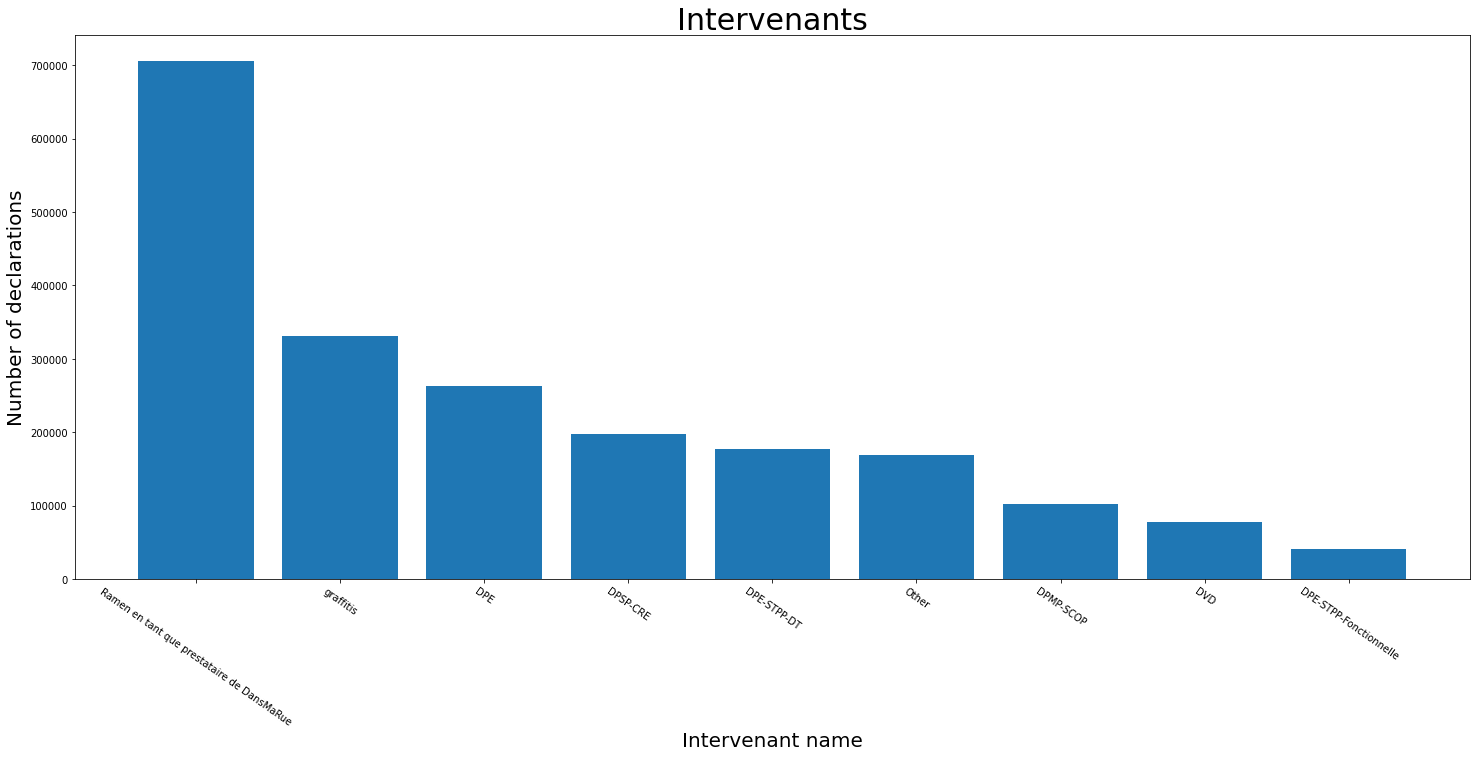

In [22]:
df_final["DATE DECLARATION"] = pd.to_datetime(
    df_final["DATE DECLARATION"], infer_datetime_format=True, dayfirst=True
)
df_intervenants = (
    df_final.groupby(["INTERVENANT"])["TYPE DECLARATION"]
    .count()
    .sort_values(ascending=False)
)
df_intervenants["Other"] = df_intervenants[8:].sum()
df_intervenants = df_intervenants.sort_values(ascending=False)
df_intervenants = df_intervenants[:9]

plt.figure(figsize=(25, 10))
plt.title("Intervenants", size=30)
plt.xlabel("Intervenant name", size=20)
plt.ylabel("Number of declarations", size=20)
plt.xticks(rotation=-35)

plt.bar(x=df_intervenants.index, height=df_intervenants.values)

plt.show()


<b>Bar chart interpretation by Operator</b>

<dl>This graph shows us the proportions of the intervention scope of each Operator</dl>
<li>We can see that the Operator 'Ramen en tant que prestataire de DansMaRue ' is the one that has the more declarations linked to it since it's the one responsible for 'Objets abandonné' which is the category the the most anomalies</li>
<li>The proportion of operators is well synchronized with the interpretations done above</li>


<AxesSubplot:title={'center':'Devices'}, xlabel='OUTIL SOURCE', ylabel='Number of declarations'>

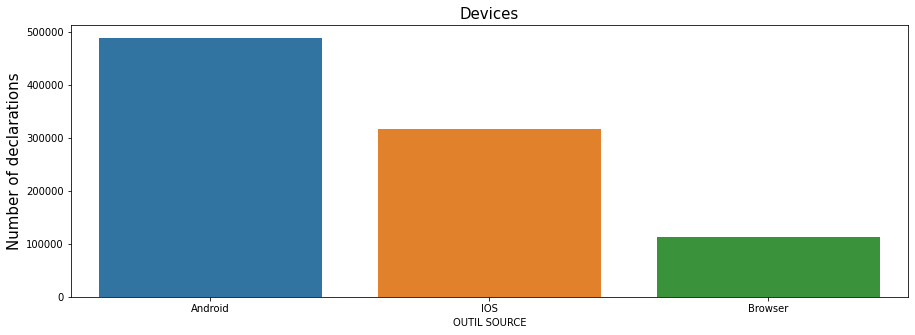

In [23]:
df_2021_2022 = get_data("DMR_2021_2022.csv.zip")

devices = df_2021_2022.groupby("OUTIL SOURCE")["OUTIL SOURCE"].count()
devices.drop("Back Office", inplace=True)
devices.rename(
    {
        "Androï": "Android",
        "IOPage DMR Paris.fr application": "IOS",
        "Page DMR Paris.fr": "Browser",
    },
    inplace=True,
)
plt.figure(figsize=(15, 5))
plt.title("Devices", size=15)
plt.xlabel("Device name", size=10)
plt.ylabel("Number of declarations", size=15)
sns.barplot(
    x=devices.index,
    y=devices.values,
)


<b>Bar chart interpretation by Device</b>

<dl>Here we can see that the most used type of device of making the declarations is Android.</dl>


<AxesSubplot:title={'center':'Correlation matrix'}>

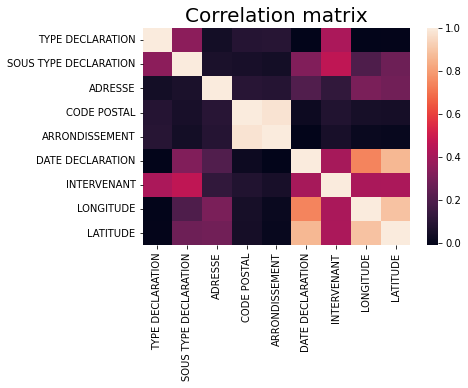

In [24]:
df_pearson_matrix = df_final.apply(lambda x: pd.factorize(x)[0]).corr(
    method="pearson", min_periods=1
)
plt.title("Correlation matrix", size=20)

sns.heatmap(df_pearson_matrix)


<b>Correlation Matrix</b>

<li>There is a correlation between the designated operators and the Type/Sub Type of declaration which is logical because each type of declaration is linked to the organism that is in charge of correcting the anomaly.</li>
